In [1]:
import anndata as ad
import gc
import sys
from scipy.sparse import csc_matrix
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LinearRegression
import random
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pickle
import heapq
import matplotlib
import os
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

batch_size = 50000
pred_num = 134

cuda


In [3]:
train_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod1.h5ad'
train_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_train_mod2.h5ad'
test_mod1_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod1.h5ad'
test_mod2_file = 'phase2_private_data/predict_modality/openproblems_bmmc_cite_phase2_rna/openproblems_bmmc_cite_phase2_rna.censor_dataset.output_test_mod2.h5ad'

In [4]:
input_train_mod1 = ad.read_h5ad(train_mod1_file)
input_train_mod2 = ad.read_h5ad(train_mod2_file)
input_test_mod1 = ad.read_h5ad(test_mod1_file)
input_test_mod2 = ad.read_h5ad(test_mod2_file)

In [5]:
print(input_train_mod1)
print(input_train_mod2)
print(input_test_mod1)
print(input_test_mod2)

AnnData object with n_obs × n_vars = 66175 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 66175 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 13953
    obs: 'batch', 'size_factors'
    var: 'gene_ids', 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'
AnnData object with n_obs × n_vars = 1000 × 134
    obs: 'batch', 'size_factors'
    var: 'feature_types'
    uns: 'dataset_id', 'organism'
    layers: 'counts'


In [6]:
print(sorted(set(input_train_mod1.obs['batch'])))
print(sorted(set(input_train_mod2.obs['batch'])))

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']


In [7]:
print(sorted(set(input_test_mod1.obs['batch'])))
print(sorted(set(input_test_mod2.obs['batch'])))

['s4d1', 's4d8', 's4d9']
['s4d1', 's4d8', 's4d9']


In [8]:
RNA_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :]
RNA_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :]
RNA_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :]
RNA_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :]
RNA_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :]
RNA_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :]

RNA_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :]
RNA_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :]
RNA_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :]

In [9]:
pro_s1d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d1", :]
pro_s1d2 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d2", :]
pro_s1d3 = input_train_mod2[input_train_mod2.obs["batch"] == "s1d3", :]
pro_s2d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d1", :]
pro_s2d4 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d4", :]
pro_s2d5 = input_train_mod2[input_train_mod2.obs["batch"] == "s2d5", :]

pro_s3d1 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d1", :]
pro_s3d6 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d6", :]
pro_s3d7 = input_train_mod2[input_train_mod2.obs["batch"] == "s3d7", :]

In [10]:
RNA_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :]
RNA_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :]
RNA_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :]

In [11]:
pro_s4d1 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d1", :]
pro_s4d8 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d8", :]
pro_s4d9 = input_test_mod2[input_test_mod2.obs["batch"] == "s4d9", :]

In [12]:
RNA_s1d1 = RNA_s1d1.X.toarray()
RNA_s1d2 = RNA_s1d2.X.toarray()
RNA_s1d3 = RNA_s1d3.X.toarray()
RNA_s2d1 = RNA_s2d1.X.toarray()
RNA_s2d4 = RNA_s2d4.X.toarray()
RNA_s2d5 = RNA_s2d5.X.toarray()

RNA_s3d1 = RNA_s3d1.X.toarray()
RNA_s3d6 = RNA_s3d6.X.toarray()
RNA_s3d7 = RNA_s3d7.X.toarray()

In [13]:
pro_s1d1 = pro_s1d1.X.toarray()
pro_s1d2 = pro_s1d2.X.toarray()
pro_s1d3 = pro_s1d3.X.toarray()
pro_s2d1 = pro_s2d1.X.toarray()
pro_s2d4 = pro_s2d4.X.toarray()
pro_s2d5 = pro_s2d5.X.toarray()

pro_s3d1 = pro_s3d1.X.toarray()
pro_s3d6 = pro_s3d6.X.toarray()
pro_s3d7 = pro_s3d7.X.toarray()

In [14]:
RNA_s4d1 = RNA_s4d1.X.toarray()
RNA_s4d8 = RNA_s4d8.X.toarray()
RNA_s4d9 = RNA_s4d9.X.toarray()

In [15]:
pro_s4d1 = pro_s4d1.X.toarray()
pro_s4d8 = pro_s4d8.X.toarray()
pro_s4d9 = pro_s4d9.X.toarray()

In [16]:
print(RNA_s1d1.shape)
print(pro_s1d1.shape)

(4721, 13953)
(4721, 134)


In [17]:
print(RNA_s4d1.shape)
print(pro_s4d1.shape)

(334, 13953)
(334, 134)


In [18]:
batch_s1d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d1", :].obs["batch"]
batch_s1d2 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d2", :].obs["batch"]
batch_s1d3 = input_train_mod1[input_train_mod1.obs["batch"] == "s1d3", :].obs["batch"]
batch_s2d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d1", :].obs["batch"]
batch_s2d4 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d4", :].obs["batch"]
batch_s2d5 = input_train_mod1[input_train_mod1.obs["batch"] == "s2d5", :].obs["batch"]

batch_s3d1 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d1", :].obs["batch"]
batch_s3d6 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d6", :].obs["batch"]
batch_s3d7 = input_train_mod1[input_train_mod1.obs["batch"] == "s3d7", :].obs["batch"]

batch_s4d1 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d1", :].obs["batch"]
batch_s4d8 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d8", :].obs["batch"]
batch_s4d9 = input_test_mod1[input_test_mod1.obs["batch"] == "s4d9", :].obs["batch"]

In [19]:
batch_train = list(batch_s1d1)+list(batch_s1d2)+list(batch_s1d3)+list(batch_s2d1)+list(batch_s2d4)+list(batch_s2d5)
batch_val = list(batch_s3d1)+list(batch_s3d6)+list(batch_s3d7)
batch_test = list(batch_s4d1)+list(batch_s4d8)+list(batch_s4d9)

In [20]:
train_input = [RNA_s1d1, RNA_s1d2, RNA_s1d3, RNA_s2d1, RNA_s2d4, RNA_s2d5]
train_output = [pro_s1d1, pro_s1d2, pro_s1d3, pro_s2d1, pro_s2d4, pro_s2d5]

val_input = [RNA_s3d1, RNA_s3d6, RNA_s3d7]
val_output = [pro_s3d1, pro_s3d6, pro_s3d7]

test_input = [RNA_s4d1, RNA_s4d8, RNA_s4d9]
test_output = [pro_s4d1, pro_s4d8, pro_s4d9]

In [21]:
# # standardize based on each batch
# for i in range(len(train_input)):
#     train_input[i] = (train_input[i]-np.mean(train_input[i]))/np.std(train_input[i])

# for i in range(len(train_output)):
#     train_output[i] = (train_output[i]-np.mean(train_output[i]))/np.std(train_output[i])

# for i in range(len(val_input)):
#     val_input[i] = (val_input[i]-np.mean(val_input[i]))/np.std(val_input[i])

# for i in range(len(val_output)):
#     val_output[i] = (val_output[i]-np.mean(val_output[i]))/np.std(val_output[i])

In [22]:
train_input = train_input + val_input
train_output = train_output + val_output

In [23]:
train_input = np.concatenate(train_input, axis=0)
val_input = np.concatenate(val_input, axis=0)
test_input = np.concatenate(test_input, axis=0)

train_output = np.concatenate(train_output, axis=0)
val_output = np.concatenate(val_output, axis=0)
test_output = np.concatenate(test_output, axis=0)

In [24]:
integrade_data_raw = pd.read_csv('gex.combined.sct.csv')
integrade_meta_raw = pd.read_csv('gex.combined.sct.obs.csv')

In [25]:
integrade_data = integrade_data_raw
integrade_meta = integrade_meta_raw

In [26]:
integrade_data = integrade_data.transpose()

In [27]:
integrade_data = integrade_data.iloc[1:, :]

In [28]:
integrade_data.reset_index(drop=True, inplace=True)
integrade_data['batch'] = integrade_meta['batch']

['s1d1', 's1d2', 's1d3', 's2d1', 's2d4', 's2d5', 's3d1', 's3d6', 's3d7']
['s4d1', 's4d8', 's4d9']

In [29]:
s1d1_integrade_data = integrade_data[integrade_data['batch'] == 's1d1']
s1d2_integrade_data = integrade_data[integrade_data['batch'] == 's1d2']
s1d3_integrade_data = integrade_data[integrade_data['batch'] == 's1d3']
s2d1_integrade_data = integrade_data[integrade_data['batch'] == 's2d1']
s2d4_integrade_data = integrade_data[integrade_data['batch'] == 's2d4']
s2d5_integrade_data = integrade_data[integrade_data['batch'] == 's2d5']
s3d1_integrade_data = integrade_data[integrade_data['batch'] == 's3d1']
s3d6_integrade_data = integrade_data[integrade_data['batch'] == 's3d6']
s3d7_integrade_data = integrade_data[integrade_data['batch'] == 's3d7']

In [30]:
s4d1_integrade_data = integrade_data[integrade_data['batch'] == 's4d1']
s4d8_integrade_data = integrade_data[integrade_data['batch'] == 's4d8']
s4d9_integrade_data = integrade_data[integrade_data['batch'] == 's4d9']

In [31]:
s1d1_inte_np = s1d1_integrade_data.iloc[:, :-1].to_numpy()
s1d2_inte_np = s1d2_integrade_data.iloc[:, :-1].to_numpy()
s1d3_inte_np = s1d3_integrade_data.iloc[:, :-1].to_numpy()
s2d1_inte_np = s2d1_integrade_data.iloc[:, :-1].to_numpy()
s2d4_inte_np = s2d4_integrade_data.iloc[:, :-1].to_numpy()
s2d5_inte_np = s2d5_integrade_data.iloc[:, :-1].to_numpy()
s3d1_inte_np = s3d1_integrade_data.iloc[:, :-1].to_numpy()
s3d6_inte_np = s3d6_integrade_data.iloc[:, :-1].to_numpy()
s3d7_inte_np = s3d7_integrade_data.iloc[:, :-1].to_numpy()

In [32]:
s4d1_inte_np = s4d1_integrade_data.iloc[:, :-1].to_numpy()
s4d8_inte_np = s4d8_integrade_data.iloc[:, :-1].to_numpy()
s4d9_inte_np = s4d9_integrade_data.iloc[:, :-1].to_numpy()

In [33]:
train_input_inte = np.concatenate([s1d1_inte_np, s1d2_inte_np, s1d3_inte_np, s2d1_inte_np, s2d4_inte_np, s2d5_inte_np, s3d1_inte_np, s3d6_inte_np, s3d7_inte_np], axis=0)
val_input_inte = np.concatenate([s3d1_inte_np, s3d6_inte_np, s3d7_inte_np], axis=0)
test_input_inte = np.concatenate([s4d1_inte_np, s4d8_inte_np, s4d9_inte_np], axis=0)

In [34]:
train_input = np.concatenate([train_input, train_input_inte], axis=1)
val_input = np.concatenate([val_input, val_input_inte], axis=1)
test_input = np.concatenate([test_input, test_input_inte], axis=1)

In [35]:
print(train_input.shape)
print(val_input.shape)
print(test_input.shape)

(66175, 16953)
(28921, 16953)
(1000, 16953)


In [36]:
train_input = np.float64(train_input)
val_input = np.float64(val_input)
test_input = np.float64(test_input)

In [37]:
train_input = torch.from_numpy(train_input)
train_output = torch.from_numpy(train_output)
val_input = torch.from_numpy(val_input)
val_output = torch.from_numpy(val_output)
test_input = torch.from_numpy(test_input)
test_output = torch.from_numpy(test_output)

In [38]:
train_input = train_input.float()
train_output = train_output.float()
val_input = val_input.float()
val_output = val_output.float()
test_input = test_input.float()
test_output = test_output.float()

In [39]:
train_input = train_input.to(device)
train_output = train_output.to(device)
val_input = val_input.to(device)
val_output = val_output.to(device)
test_input = test_input.to(device)
test_output = test_output.to(device)

In [40]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_train)):
    if batch_train[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_train[i]] = k
    batch_train[i] = batch_lib[batch_train[i]]

In [41]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_val)):
    if batch_val[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_val[i]] = k
    batch_val[i] = batch_lib[batch_val[i]]

In [42]:
colors = ['red','green','blue','purple', 'yellow', 'orange']
k = 0
batch_lib = {}
for i in range(len(batch_test)):
    if batch_test[i] not in batch_lib:
        k = k + 1
        batch_lib[batch_test[i]] = k
    batch_test[i] = batch_lib[batch_test[i]]

In [43]:
batch_train = batch_train + batch_val

In [44]:
train_output = train_output[:, 0:pred_num]
train_output.shape

torch.Size([66175, 134])

In [45]:
val_output = val_output[:, 0:pred_num]
val_output.shape

torch.Size([28921, 134])

In [46]:
test_output = test_output[:, 0:pred_num]
test_output.shape

torch.Size([1000, 134])

In [47]:
train_ds = TensorDataset(train_input, train_output)
train_dl = DataLoader(train_ds, batch_size= batch_size, shuffle=True)

In [48]:
input_feature = train_input.shape[1]
output_feature = pred_num

In [49]:
# auto-encoder model
# base model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.linear1 = nn.Linear(input_feature, input_feature//16)
        self.linear2 = nn.Linear(input_feature//2, input_feature//4)
        self.linear3 = nn.Linear(input_feature//4, input_feature//8)
        self.linear4 = nn.Linear(input_feature//8, input_feature//16)
        
        self.linear5 = nn.Linear(input_feature//16, pred_num)
        self.relu = nn.ReLU()
        self.leakyrelu = nn.LeakyReLU(0.1)
        self.dropout = nn.Dropout(0.15)
        
        self.linear = nn.Linear(input_feature, pred_num)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        
#         x = self.linear2(x)
#         x = self.relu(x)
#         x = self.dropout(x)
        
#         x = self.linear3(x)
#         x = self.relu(x)
        
#         x = self.linear4(x)
#         x = self.relu(x)
        
        output = self.linear5(x)
        
        return output.float()

In [50]:
PATH = 'No_norm_model_RNA_pro_with_inte'

In [51]:
def fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output):
    # plt.rcParams['figure.figsize'] = [40, 40]
    val_best = float('inf')
    train_pred_output = []
    val_pred_output = []
    for epoch in range(num_epochs):
        for x,y in train_dl:
            model = model.train()
            pred = model(x)
            # print(y.shape, pred.shape)
            # y = torch.reshape(y, (y.shape[0], 1))
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            opt.zero_grad()

        if epoch % 100 == 0:
            model = model.eval()
            
            train_pred = model(train_input)
            # train_output = torch.reshape(train_output, (train_output.shape[0], 1))
            train_loss = loss_fn(train_pred, train_output)
            train_loss = torch.sqrt(train_loss)
            train_loss = train_loss.cpu().detach().numpy()
            
            val_pred = model(val_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            val_loss = loss_fn(val_pred, val_output)
            val_loss = torch.sqrt(val_loss)
            val_loss = val_loss.cpu().detach().numpy()
            
            test_pred = model(test_input)
            # val_output = torch.reshape(val_output, (val_output.shape[0], 1))
            test_loss = loss_fn(test_pred, test_output)
            test_loss = torch.sqrt(test_loss)
            test_loss = test_loss.cpu().detach().numpy()
            
            if val_loss < val_best:
                torch.save(model.state_dict(), PATH)
                val_best = val_loss
                
            print('Epoch ', epoch, 'Train_loss: ', train_loss, ' Validation_loss: ', val_loss, ' Test_loss: ', test_loss)
        if epoch % 1000 == 0:
            colors = ['red','green','blue','purple', 'yellow', 'orange']
            figure, ax = plt.subplots(1, 3, figsize = (10, 4*1))
            for i in range(1):
                ax[0].scatter(train_output.cpu().detach().numpy()[:, 0], train_pred.cpu().detach().numpy()[:, 0], c=batch_train, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[0].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[0].set_title('Train data result ' + str(i+1))
                ax[0].set_xlabel('train')
                ax[0].set_ylabel('pred')

                ax[1].scatter(val_output.cpu().detach().numpy()[:, 0], val_pred.cpu().detach().numpy()[:, 0], c=batch_val, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[1].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[1].set_title('Validation data result ' + str(i+1))
                ax[1].set_xlabel('true')
                ax[1].set_ylabel('pred')

                ax[2].scatter(test_output.cpu().detach().numpy()[:, 0], test_pred.cpu().detach().numpy()[:, 0], c=batch_test, cmap=matplotlib.colors.ListedColormap(colors), s = 30, alpha=0.3)
                ax[2].plot([-1.5, 3], [-1.5, 3], 'k-')
                ax[2].set_title('Test data result ' + str(i+1))
                ax[2].set_xlabel('true')
                ax[2].set_ylabel('pred')
            
            plt.show()
            # train_pred_output.append([train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy()])
            # val_pred_output.append([val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()])
    return train_pred.cpu().detach().numpy(), train_output.cpu().detach().numpy(), val_pred.cpu().detach().numpy(), val_output.cpu().detach().numpy()

Epoch  0 Train_loss:  1.0117232  Validation_loss:  0.86834884  Test_loss:  1.1815516


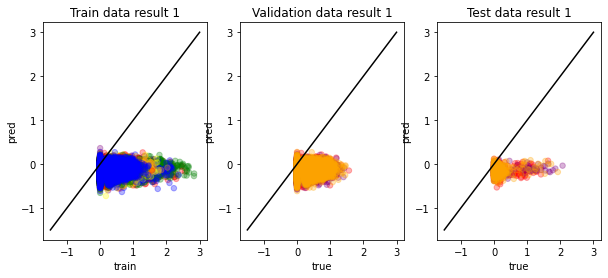

Epoch  100 Train_loss:  0.4864254  Validation_loss:  0.4283684  Test_loss:  0.52021575
Epoch  200 Train_loss:  0.45744655  Validation_loss:  0.4119787  Test_loss:  0.48564208
Epoch  300 Train_loss:  0.44191626  Validation_loss:  0.40116656  Test_loss:  0.4692137
Epoch  400 Train_loss:  0.43187484  Validation_loss:  0.3929072  Test_loss:  0.4606743
Epoch  500 Train_loss:  0.42444623  Validation_loss:  0.386077  Test_loss:  0.4552255
Epoch  600 Train_loss:  0.4183881  Validation_loss:  0.37998512  Test_loss:  0.45130754
Epoch  700 Train_loss:  0.41314936  Validation_loss:  0.37455854  Test_loss:  0.4481432
Epoch  800 Train_loss:  0.40847746  Validation_loss:  0.36954343  Test_loss:  0.44552153
Epoch  900 Train_loss:  0.40424475  Validation_loss:  0.36498386  Test_loss:  0.44334126
Epoch  1000 Train_loss:  0.40037408  Validation_loss:  0.36077142  Test_loss:  0.44148788


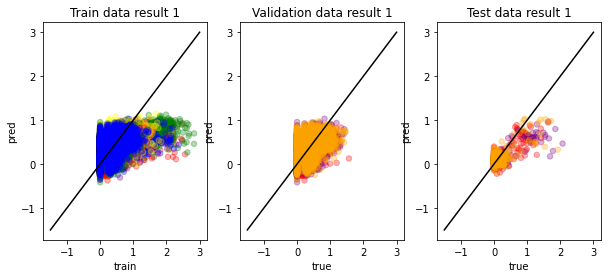

Epoch  1100 Train_loss:  0.39682376  Validation_loss:  0.35687172  Test_loss:  0.4400159
Epoch  1200 Train_loss:  0.39356157  Validation_loss:  0.35324126  Test_loss:  0.43882698
Epoch  1300 Train_loss:  0.39055607  Validation_loss:  0.34994024  Test_loss:  0.437932
Epoch  1400 Train_loss:  0.3877864  Validation_loss:  0.3468461  Test_loss:  0.43718454
Epoch  1500 Train_loss:  0.3852331  Validation_loss:  0.34399736  Test_loss:  0.43657097
Epoch  1600 Train_loss:  0.38287154  Validation_loss:  0.34142157  Test_loss:  0.43609023
Epoch  1700 Train_loss:  0.38069573  Validation_loss:  0.3389344  Test_loss:  0.43585375
Epoch  1800 Train_loss:  0.37867177  Validation_loss:  0.33670527  Test_loss:  0.43567735
Epoch  1900 Train_loss:  0.37678492  Validation_loss:  0.33465624  Test_loss:  0.43552878
Epoch  2000 Train_loss:  0.37503093  Validation_loss:  0.33269832  Test_loss:  0.43546033


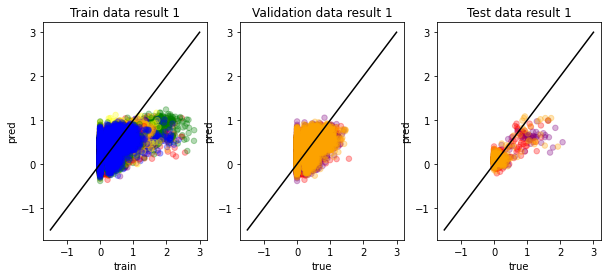

Epoch  2100 Train_loss:  0.3733875  Validation_loss:  0.33089972  Test_loss:  0.43550435
Epoch  2200 Train_loss:  0.37183863  Validation_loss:  0.32926854  Test_loss:  0.43544227
Epoch  2300 Train_loss:  0.37038204  Validation_loss:  0.32769424  Test_loss:  0.43541756
Epoch  2400 Train_loss:  0.36900738  Validation_loss:  0.32624635  Test_loss:  0.4355111
Epoch  2500 Train_loss:  0.3677055  Validation_loss:  0.3248909  Test_loss:  0.4356786
Epoch  2600 Train_loss:  0.36645883  Validation_loss:  0.32360736  Test_loss:  0.43567798
Epoch  2700 Train_loss:  0.3652752  Validation_loss:  0.32237518  Test_loss:  0.4357586
Epoch  2800 Train_loss:  0.3641397  Validation_loss:  0.32127073  Test_loss:  0.435821
Epoch  2900 Train_loss:  0.36305863  Validation_loss:  0.3201589  Test_loss:  0.43596646
Epoch  3000 Train_loss:  0.36201218  Validation_loss:  0.31918067  Test_loss:  0.436027


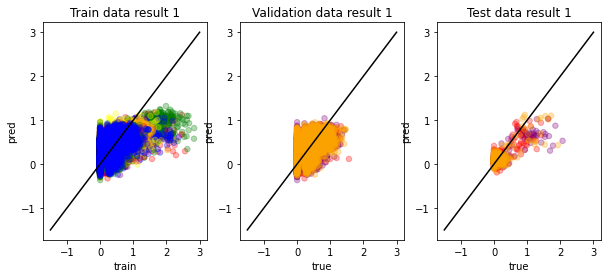

Epoch  3100 Train_loss:  0.36100742  Validation_loss:  0.31818235  Test_loss:  0.43610173
Epoch  3200 Train_loss:  0.3600403  Validation_loss:  0.31726098  Test_loss:  0.43615538
Epoch  3300 Train_loss:  0.35910773  Validation_loss:  0.31633922  Test_loss:  0.43625915
Epoch  3400 Train_loss:  0.35819978  Validation_loss:  0.31551313  Test_loss:  0.43631518
Epoch  3500 Train_loss:  0.3573258  Validation_loss:  0.31469196  Test_loss:  0.43641552
Epoch  3600 Train_loss:  0.35647357  Validation_loss:  0.3139288  Test_loss:  0.4364422
Epoch  3700 Train_loss:  0.35565248  Validation_loss:  0.31314772  Test_loss:  0.4365461
Epoch  3800 Train_loss:  0.35485145  Validation_loss:  0.31243604  Test_loss:  0.43667182
Epoch  3900 Train_loss:  0.35407448  Validation_loss:  0.31170905  Test_loss:  0.43676496
Epoch  4000 Train_loss:  0.35331437  Validation_loss:  0.31102657  Test_loss:  0.43682957


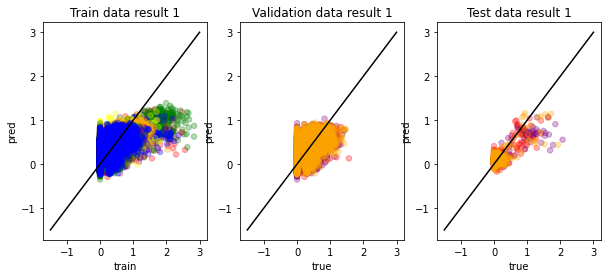

Epoch  4100 Train_loss:  0.352573  Validation_loss:  0.31037864  Test_loss:  0.43681982
Epoch  4200 Train_loss:  0.35185182  Validation_loss:  0.30975208  Test_loss:  0.43690068
Epoch  4300 Train_loss:  0.35114986  Validation_loss:  0.30911842  Test_loss:  0.43702617
Epoch  4400 Train_loss:  0.35046214  Validation_loss:  0.30853248  Test_loss:  0.43705153
Epoch  4500 Train_loss:  0.34979206  Validation_loss:  0.30795094  Test_loss:  0.4370752
Epoch  4600 Train_loss:  0.34913605  Validation_loss:  0.30739915  Test_loss:  0.4371564
Epoch  4700 Train_loss:  0.34849608  Validation_loss:  0.30684185  Test_loss:  0.43725035
Epoch  4800 Train_loss:  0.34786624  Validation_loss:  0.30632767  Test_loss:  0.43720123
Epoch  4900 Train_loss:  0.34725535  Validation_loss:  0.3058035  Test_loss:  0.43727472
Epoch  5000 Train_loss:  0.3466547  Validation_loss:  0.30528778  Test_loss:  0.43736184


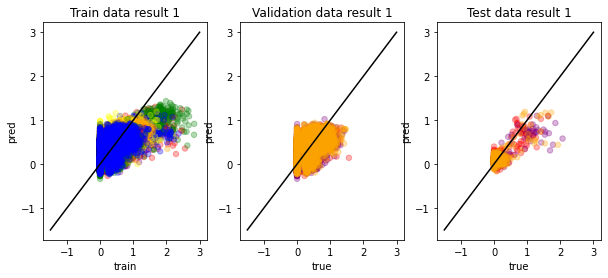

Epoch  5100 Train_loss:  0.34606716  Validation_loss:  0.30480433  Test_loss:  0.43740845
Epoch  5200 Train_loss:  0.3454907  Validation_loss:  0.30434015  Test_loss:  0.4374372
Epoch  5300 Train_loss:  0.34492543  Validation_loss:  0.3038565  Test_loss:  0.43740535
Epoch  5400 Train_loss:  0.34437555  Validation_loss:  0.303389  Test_loss:  0.43749887
Epoch  5500 Train_loss:  0.34383237  Validation_loss:  0.3029506  Test_loss:  0.43753034
Epoch  5600 Train_loss:  0.34329993  Validation_loss:  0.3025228  Test_loss:  0.4375648
Epoch  5700 Train_loss:  0.34277833  Validation_loss:  0.30209225  Test_loss:  0.43756184
Epoch  5800 Train_loss:  0.3422664  Validation_loss:  0.30167955  Test_loss:  0.43762565
Epoch  5900 Train_loss:  0.3417601  Validation_loss:  0.30128747  Test_loss:  0.43757102
Epoch  6000 Train_loss:  0.34126934  Validation_loss:  0.30088127  Test_loss:  0.43769857


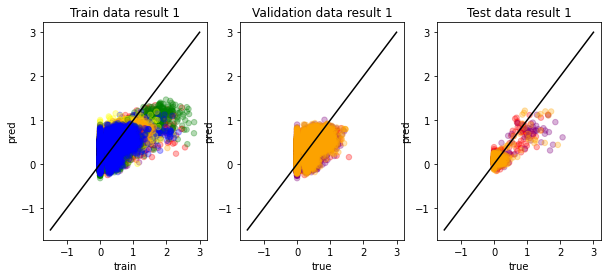

Epoch  6100 Train_loss:  0.34078336  Validation_loss:  0.3004883  Test_loss:  0.43765426
Epoch  6200 Train_loss:  0.34030446  Validation_loss:  0.30011034  Test_loss:  0.4376703
Epoch  6300 Train_loss:  0.33983833  Validation_loss:  0.29973382  Test_loss:  0.43771276
Epoch  6400 Train_loss:  0.33937815  Validation_loss:  0.29937425  Test_loss:  0.4377451
Epoch  6500 Train_loss:  0.33892548  Validation_loss:  0.299023  Test_loss:  0.4377477
Epoch  6600 Train_loss:  0.33847967  Validation_loss:  0.29867637  Test_loss:  0.43773156
Epoch  6700 Train_loss:  0.33804417  Validation_loss:  0.29832917  Test_loss:  0.43777558
Epoch  6800 Train_loss:  0.33761266  Validation_loss:  0.29798776  Test_loss:  0.43778285
Epoch  6900 Train_loss:  0.33718565  Validation_loss:  0.29766428  Test_loss:  0.43772364
Epoch  7000 Train_loss:  0.33676988  Validation_loss:  0.2973355  Test_loss:  0.4377551


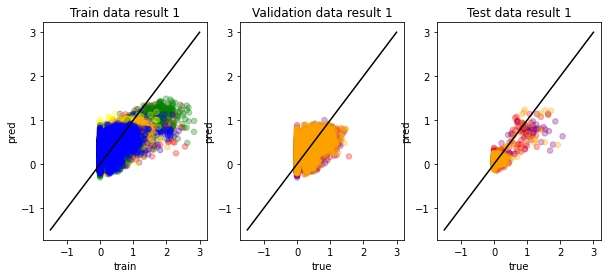

Epoch  7100 Train_loss:  0.33636433  Validation_loss:  0.29700935  Test_loss:  0.43783662
Epoch  7200 Train_loss:  0.33595917  Validation_loss:  0.29670808  Test_loss:  0.4378372
Epoch  7300 Train_loss:  0.33555973  Validation_loss:  0.29639408  Test_loss:  0.43776205
Epoch  7400 Train_loss:  0.33516487  Validation_loss:  0.29610363  Test_loss:  0.43775043
Epoch  7500 Train_loss:  0.33478183  Validation_loss:  0.29579908  Test_loss:  0.43781638
Epoch  7600 Train_loss:  0.3344019  Validation_loss:  0.2955051  Test_loss:  0.43780205
Epoch  7700 Train_loss:  0.33402795  Validation_loss:  0.2952177  Test_loss:  0.43779492
Epoch  7800 Train_loss:  0.33365753  Validation_loss:  0.29494858  Test_loss:  0.43781465
Epoch  7900 Train_loss:  0.3332941  Validation_loss:  0.29465598  Test_loss:  0.437808
Epoch  8000 Train_loss:  0.33293545  Validation_loss:  0.29439035  Test_loss:  0.4377453


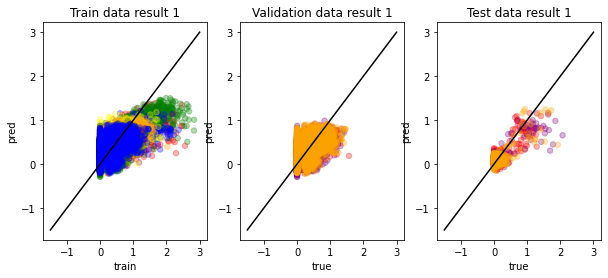

Epoch  8100 Train_loss:  0.3325814  Validation_loss:  0.29411006  Test_loss:  0.43776414
Epoch  8200 Train_loss:  0.33223352  Validation_loss:  0.2938586  Test_loss:  0.4377942
Epoch  8300 Train_loss:  0.3318916  Validation_loss:  0.29357716  Test_loss:  0.4378086
Epoch  8400 Train_loss:  0.33154887  Validation_loss:  0.29334444  Test_loss:  0.43771017
Epoch  8500 Train_loss:  0.3312162  Validation_loss:  0.29307723  Test_loss:  0.43772745
Epoch  8600 Train_loss:  0.33088562  Validation_loss:  0.29283068  Test_loss:  0.43771887
Epoch  8700 Train_loss:  0.33055887  Validation_loss:  0.29258412  Test_loss:  0.43770528
Epoch  8800 Train_loss:  0.3302404  Validation_loss:  0.2923342  Test_loss:  0.4377748
Epoch  8900 Train_loss:  0.32992074  Validation_loss:  0.29209197  Test_loss:  0.4376944
Epoch  9000 Train_loss:  0.32960826  Validation_loss:  0.29186025  Test_loss:  0.43771797


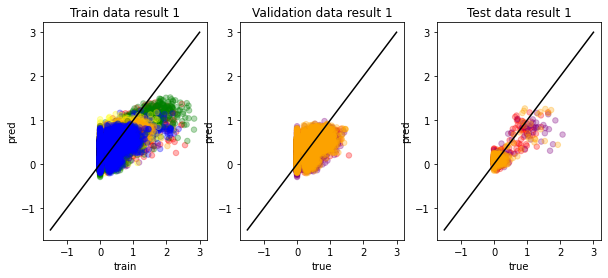

Epoch  9100 Train_loss:  0.32929635  Validation_loss:  0.29163054  Test_loss:  0.43764865
Epoch  9200 Train_loss:  0.3289908  Validation_loss:  0.29140374  Test_loss:  0.43762693
Epoch  9300 Train_loss:  0.328691  Validation_loss:  0.2911749  Test_loss:  0.43766806
Epoch  9400 Train_loss:  0.32839152  Validation_loss:  0.29094747  Test_loss:  0.43762794
Epoch  9500 Train_loss:  0.32809737  Validation_loss:  0.29072595  Test_loss:  0.43759874
Epoch  9600 Train_loss:  0.32780653  Validation_loss:  0.29051173  Test_loss:  0.43758482
Epoch  9700 Train_loss:  0.3275203  Validation_loss:  0.290299  Test_loss:  0.43761137
Epoch  9800 Train_loss:  0.32723173  Validation_loss:  0.29008928  Test_loss:  0.43753114
Epoch  9900 Train_loss:  0.32695234  Validation_loss:  0.28987554  Test_loss:  0.43751377


In [52]:
num_epochs = 10000
learning_rate = 0.001
latent_dim = 50
loss_fn = F.mse_loss
batch_size = 50000

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
    
model = Autoencoder()
# model.load_state_dict(torch.load('Batch_feature_norm_model'))
model = model.to(device)
opt = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
train_pred_np, train_output_np, val_pred_np, val_output_np = fit(num_epochs, model, loss_fn, train_input, train_output, val_input, val_output, test_input, test_output)